In [31]:
import collections

Sample = collections.namedtuple(
  'Sample', ['timestamp', 'gnss_easting', 'gnss_northing', 'odom_drive', 'odom_steer', 'lidar'])

In [30]:
import csv
def read_log(file):
  reader = csv.reader(file)
  result = []
  for line in reader:
    result.append(Sample(
        float(line[0]), 
        float(line[1]), 
        float(line[2]), 
        float(line[3]), 
        float(line[4]), 
        list(map(lambda i: (float(line[i]), float(line[i + 1])), range(5, len(line), 2)))
        ))
  return result

In [32]:
import math
WHEELBASE_LENGTH = 0.32
Pose = collections.namedtuple('Pose', ['x', 'y', 'theta'])
def parse_odometry(log):
  poses = [Pose(0.0, 0.0, 0.0)]
  prev_samp = log[0]
  for samp in log[1::]:
    # https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    dt = samp.timestamp - prev_samp.timestamp
    poses.append(
      Pose(
        poses[-1].x + (samp.odom_drive * dt * math.cos(poses[-1].theta)), 
        poses[-1].y + (samp.odom_drive * dt * math.sin(poses[-1].theta)), 
        poses[-1].theta + (samp.odom_drive * dt * math.tan(samp.odom_steer) * (1 / WHEELBASE_LENGTH))
        )
      )
    prev_samp = samp
  return poses


In [33]:
Trans = collections.namedtuple('Trans', ['x', 'y'])

def parse_lidar(path, log):
  detections = []
  for (samp, pose) in zip(log, path):
    for (i, lidar) in enumerate(samp.lidar):
      if lidar[0] == 0 and lidar[1] == 0:
        continue
      theta = -(pose.theta + math.atan2(lidar[1], lidar[0]))
      x = math.cos(theta) * math.sqrt(lidar[0] ** 2 + lidar[1] ** 2)
      y = math.sin(theta) * math.sqrt(lidar[0] ** 2 + lidar[1] ** 2)
      detections.append(
        Trans(
          pose.x + x,
          pose.y + y
        )
    )
  return detections

In [166]:
def bresenham2D(sx, sy, ex, ey):
  '''
  Bresenham's ray tracing algorithm in 2D.
  Inputs:
      (sx, sy)    start point of ray
      (ex, ey)    end point of ray
  '''
  sx = int(round(sx))
  sy = int(round(sy))
  ex = int(round(ex))
  ey = int(round(ey))
  dx = abs(ex-sx)
  dy = abs(ey-sy)
  steep = abs(dy)>abs(dx)
  if steep:
    dx,dy = dy,dx # swap 

  if dy == 0:
    q = np.zeros((dx+1,1))
  else:
    q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
  if steep:
    if sy <= ey:
      y = np.arange(sy,ey+1)
    else:
      y = np.arange(sy,ey-1,-1)
    if sx <= ex:
      x = sx + np.cumsum(q)
    else:
      x = sx - np.cumsum(q)
  else:
    if sx <= ex:
      x = np.arange(sx,ex+1)
    else:
      x = np.arange(sx,ex-1,-1)
    if sy <= ey:
      y = sy + np.cumsum(q)
    else:
      y = sy - np.cumsum(q)
  return np.stack((x,y), axis=1).astype(int)


In [308]:
import numpy as np


GRID_RESOLUTION = 0.1
LOG_TRUST = 1.5
LAMBDA_MAX = 128.0

def world_to_grid(pose, minmax, num_rows, num_cols):
    (min_x, min_y, max_x, max_y) = minmax
    x, y = (pose[0], pose[1])
    # Convert pose to grid cell index based on resolution
    row = int(math.ceil(((y - min_y) / (max_y - min_y)) * num_rows))
    col = int(math.ceil(((x - min_x) / (max_x - min_x)) * num_cols))
    return (row, col)

def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def generate_count_grid(detections: list, log: list[Sample], poses: list):
    world_poses = detections + list(map(lambda p: Trans(p.x, p.y), poses))
    print(world_poses)
    min_x = min(map(lambda d: d[0], world_poses)) - GRID_RESOLUTION * 2
    min_y = min(map(lambda d: d[1], world_poses)) - GRID_RESOLUTION * 2
    max_x = max(map(lambda d: d[0], world_poses)) + GRID_RESOLUTION * 2
    max_y = max(map(lambda d: d[1], world_poses)) + GRID_RESOLUTION * 2
    minmax = (min_x, min_y, max_x, max_y)
    print(f"x [{min_x}, {max_x}] y [{min_y}, {max_y}]")
    num_cols, num_rows = (int(math.ceil((max_x - min_x) / GRID_RESOLUTION)), int(math.ceil((max_y - min_y) / GRID_RESOLUTION)))
    print(f"{num_rows} rows by {num_cols} cols")
    
    # Initialize the grid with zeros
    grid = [[0.0 for _ in range(num_cols)] for _ in range(num_rows)]
    dets = []

    # Count poses in the grid
    for (samp, pose) in zip(log, poses):
        r_row, r_col = world_to_grid(pose, minmax, num_rows, num_cols)
        for detection in samp.lidar:
            if detection[0] == 0 and detection[1] == 0:
                continue
            d_theta = -(pose.theta + math.atan2(detection[1], detection[0]))
            d_x = math.cos(d_theta) * math.sqrt(detection[0] ** 2 + detection[1] ** 2)
            d_y = math.sin(d_theta) * math.sqrt(detection[0] ** 2 + detection[1] ** 2)
            d_world = Trans(d_x + pose.x, d_y + pose.y)
            dets.append(d_world)
            
            d_row, d_col = world_to_grid(d_world, minmax, num_rows, num_cols)
            # try:
            grid[d_row][d_col] += math.log(LOG_TRUST)
            grid[d_row][d_col] = clamp(grid[d_row][d_col], -LAMBDA_MAX, LAMBDA_MAX)
            # except IndexError:
                # print(f"{d_row}, {d_col}")
            
            for (e_row, e_col) in bresenham2D(r_row, r_col, d_row, d_col):
                grid[e_row][e_col] -= math.log(LOG_TRUST)
                grid[e_row][e_col] = clamp(grid[e_row][e_col], -LAMBDA_MAX, LAMBDA_MAX)
    grid = list(map(lambda r: list(map(lambda x: math.exp(x) / (1 + math.exp(x)), r)), grid))
    print(grid)
    return (grid, (min_x, max_x, min_y, max_y), dets)

[Sample(timestamp=0.0, gnss_easting=0.2, gnss_northing=0.0, odom_drive=2.0, odom_steer=0.00894493956168725, lidar=[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5516157583640934, 1.331718245061314), (0.35217720603844677, 1.1609726595670042), (0.21793873810810732, 1.09565202495496), (0.10360970989791408, 1.051967038404244), (6.25195062627778e-17, 1.021021021021021), (-0.10007756069684871, 1.0161045257313723), (-0.199191319776227, 1.0014023883996948), (-0.3068474666473594, 1.011540535068281), (-0.42750221273217226, 1.0320816399225183), (-0.5775671730480693, 1.0805521797421287), (-0.8208425064433759, 1.2284776253839411), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.7941484411931

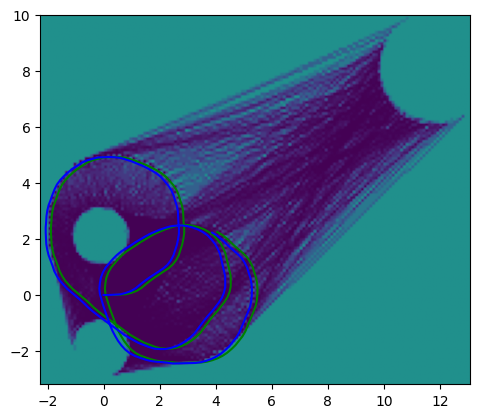

In [328]:
import matplotlib.pyplot as plt
test_log = read_log(open('./test_log.log', 'r'))
print(test_log)
odometry = parse_odometry(test_log)
print(odometry)
detections = parse_lidar(odometry, test_log)
print(detections)

# show odo
fig, ax1 = plt.subplots()
# ax1.set_ymargin(1.0)
# ax1.set_xmargin(1.0)
omap = generate_count_grid(detections, test_log, odometry)
# for r in omap[0]:
#   print(str(r) + "\n")
ax1.imshow(omap[0], extent=omap[1], origin='lower', vmin=0.0, vmax=1.0)
ax1.plot(list(map(lambda samp: samp.gnss_easting, test_log)), list(map(lambda samp: samp.gnss_northing, test_log)), color='green')
# ax1.scatter(list(map(lambda trans: trans.x, omap[2])), list(map(lambda trans: trans.y, omap[2])), color='red')
ax1.plot(list(map(lambda pose: pose.x, odometry)), list(map(lambda pose: pose.y, odometry)), color='blue')
ax1.margins(0.5)
ax1.set_aspect('equal')
plt.show()